In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'
white_df = pd.read_csv(URL, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')

In [3]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])

8.8
9.1


In [4]:
# Pre-process
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
red_df = pd.read_csv(URL, sep=";")

red_df["is_red"] = 1
red_df = red_df.drop_duplicates(keep='first')

In [5]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])

9.4
10.2


In [6]:
# Concatenate the datasets
df = pd.concat([red_df, white_df], ignore_index=True)

In [7]:
print(df.alcohol[0])
print(df.alcohol[100])

9.4
9.5


In [8]:
# shuffle the data
df = df.iloc[np.random.permutation(len(df))]

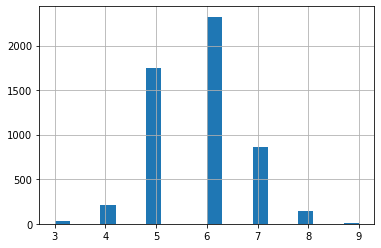

In [9]:
df['quality'].hist(bins=20); 

In [10]:
# Imbalanced data
df = df[(df['quality'] > 4) & (df['quality'] < 8 )]

# reset index and drop the old one
df = df.reset_index(drop=True)

In [11]:
print(df.alcohol[0])
print(df.alcohol[100])

10.6
9.0


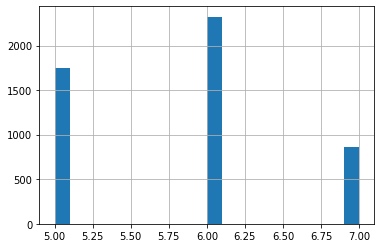

In [12]:
df['quality'].hist(bins=20);

In [13]:
# Train Test Split
# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

In [14]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

In [15]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.213677,1.291486,4.20000,6.4000,7.00000,7.7000,15.50000
volatile acidity,3155.0,0.338758,0.164656,0.08000,0.2300,0.29000,0.4000,1.33000
citric acid,3155.0,0.320460,0.146977,0.00000,0.2500,0.31000,0.4000,1.66000
residual sugar,3155.0,5.108415,4.604200,0.60000,1.8000,2.70000,7.6000,65.80000
chlorides,3155.0,0.056841,0.036682,0.01200,0.0380,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.211094,17.140629,1.00000,17.0000,28.00000,41.0000,128.00000
total sulfur dioxide,3155.0,114.854992,56.385701,6.00000,76.0000,117.00000,154.0000,344.00000
density,3155.0,0.994586,0.002972,0.98711,0.9923,0.99471,0.9968,1.03898
pH,3155.0,3.222913,0.157980,2.72000,3.1200,3.21000,3.3200,4.01000
sulphates,3155.0,0.535255,0.148562,0.23000,0.4400,0.51000,0.6000,1.95000


In [16]:
# Get the labels
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [17]:
# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)
    
# format the output of the test set
test_Y = format_output(test)

In [18]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,6.5,0.21,0.40,7.3,0.041,49.0,115.0,0.99268,3.21,0.43,11.0
3557,7.5,0.19,0.34,2.6,0.037,33.0,125.0,0.99230,3.10,0.49,11.1
3825,9.2,0.43,0.49,2.4,0.086,23.0,116.0,0.99760,3.23,0.64,9.5
1740,5.9,0.25,0.19,12.4,0.047,50.0,162.0,0.99730,3.35,0.38,9.5
1221,5.7,0.15,0.28,3.7,0.045,57.0,151.0,0.99130,3.22,0.27,11.2


In [19]:
# Normalize the data
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [20]:
# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

In [21]:
def base_model(inputs):
    x = Dense(128, activation="relu", name="dense1")(inputs)
    x = Dense(128, activation="relu", name="dense2")(x)
    return x

In [22]:
# output layers
def final_model(inputs):
    x = base_model(inputs)
    # regression
    wine_quality = Dense(units='1', name='wine_quality')(x)
    # classification
    wine_type = Dense(units='1', activation="sigmoid", name='wine_type')(x)
    model = Model(inputs=inputs, outputs=[wine_quality, wine_type] )
    return model

In [23]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
              loss = {'wine_type' : "binary_crossentropy",
                      'wine_quality' : "mse"
                     },
              metrics = {'wine_type' : "accuracy",
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                       }
             )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [24]:
cb_cp = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_weights_only=True, save_best_only=True, monitor="loss")

In [25]:
history = model.fit(norm_train_X, train_Y,
                    epochs=100, validation_data=(norm_val_X, val_Y),
                    callbacks=[cb_cp])

model.load_weights("best_model.h5")

Epoch 1/100
99/99 [==============================] - 4s 6ms/step - loss: 25.8981 - wine_quality_loss: 25.2072 - wine_type_loss: 0.6908 - wine_quality_root_mean_squared_error: 5.0207 - wine_type_accuracy: 0.5217 - val_loss: 18.4168 - val_wine_quality_loss: 17.7343 - val_wine_type_loss: 0.6826 - val_wine_quality_root_mean_squared_error: 4.2112 - val_wine_type_accuracy: 0.5539
Epoch 2/100
99/99 [==============================] - 0s 4ms/step - loss: 12.8881 - wine_quality_loss: 12.2207 - wine_type_loss: 0.6673 - wine_quality_root_mean_squared_error: 3.4958 - wine_type_accuracy: 0.6158 - val_loss: 7.5956 - val_wine_quality_loss: 6.9467 - val_wine_type_loss: 0.6489 - val_wine_quality_root_mean_squared_error: 2.6357 - val_wine_type_accuracy: 0.6502
Epoch 3/100
99/99 [==============================] - 0s 4ms/step - loss: 5.2455 - wine_quality_loss: 4.6417 - wine_type_loss: 0.6039 - wine_quality_root_mean_squared_error: 2.1545 - wine_type_accuracy: 0.7179 - val_loss: 3.3615 - val_wine_quality_l

In [26]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

25/25 [==============================] - 0s 3ms/step - loss: 0.3760 - wine_quality_loss: 0.3519 - wine_type_loss: 0.0241 - wine_quality_root_mean_squared_error: 0.5932 - wine_type_accuracy: 0.9975

loss: 0.37600958347320557
wine_quality_loss: 0.35186120867729187
wine_type_loss: 0.024148356169462204
wine_quality_rmse: 0.593178927898407
wine_type_accuracy: 0.9974651336669922


In [27]:
# Performance
predictions = model.predict(norm_test_X)

# two outputs.
quality_pred = predictions[0]
type_pred = predictions[1]

In [28]:
print(quality_pred[0])

[5.4674115]


In [29]:
print(type_pred[0])
print(type_pred[944])

[0.0021055]
[0.00162186]


In [30]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [31]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

In [32]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

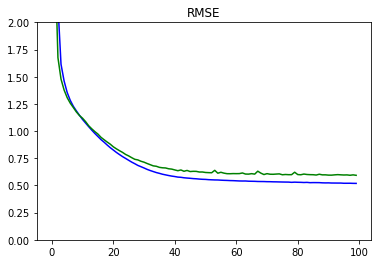

In [33]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

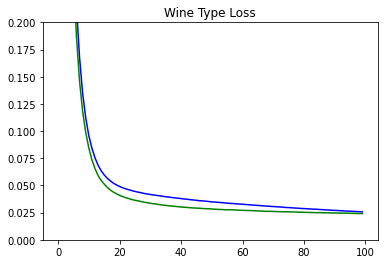

In [34]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

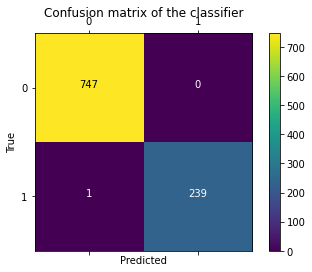

In [35]:
# Confusion Matrix
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

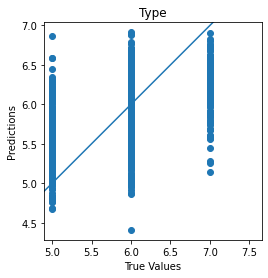

In [36]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')